# Week 4 Project

This project is based on the BBC News Classification competition on Kaggle found at https://www.kaggle.com/competitions/learn-ai-bbc/data. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


Load Data

In [5]:
train = pd.read_csv("learn-ai-bbc/BBC News Train.csv")
test = pd.read_csv("learn-ai-bbc/BBC News Test.csv")
train.drop_duplicates(subset=["Text"], inplace=True)
print(train.shape, test.shape)

(1440, 3) (735, 2)


### EDA

We will inspect our data and use some visualizations to understand it. The histogram shows a balanced dataset across all 5 categories so this will help our model. An unbalanced dataset would lead to an unbalanced model.

In [3]:
print(train.tail())
print(train.info())
print(train.nunique())

      ArticleId                                               Text  \
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
1485  entertainment  
1486  entertainment  
1487       business  
1488           tech  
1489           tech  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1440 non-null   int64 
 1   Text       1440 non-null   object
 2   Category   1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.0+ KB
None
ArticleId    1440
Text         1440
Category        5
dtype: int64


(array([335.,   0., 234.,   0.,   0., 266.,   0., 342.,   0., 263.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

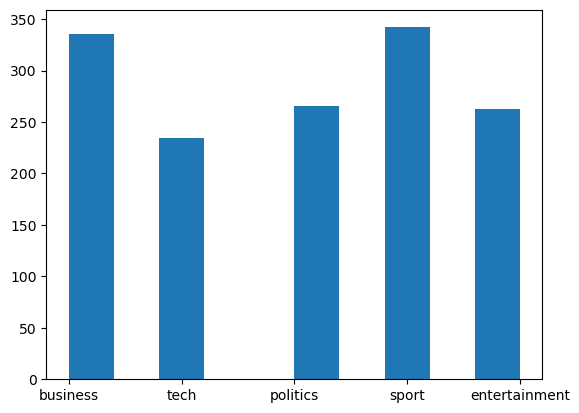

In [4]:
plt.hist(train.Category)

Here we expore the size of the text and compare the article lengths.

Mean text length:  2234.2618055555554  Min length:  501  Max length:  18387


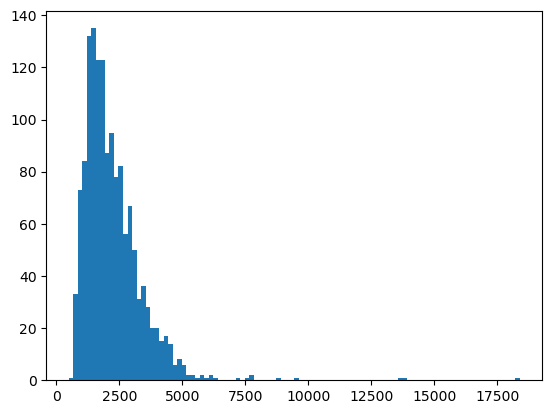

In [5]:
train["Text_len"] = train.Text.apply(lambda x: len(x))
print("Mean text length: ", np.mean(train.Text_len)," Min length: ", np.min(train.Text_len)," Max length: ", np.max(train.Text_len))
plt.hist(train.Text_len, bins=100)
plt.show()

In [7]:
print("\nOriginal train shape:", train.shape)
print("The mean number of category is ", train.Category.value_counts().mean())
print(train.Category.value_counts())


Original train shape: (1440, 4)
The mean number of category is  288.0
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: Category, dtype: int64


In [37]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(train.Text).toarray()
labels = train.Category

In [38]:
features.shape

(1440, 9477)

In [39]:
tsne = TSNE(n_components=2, random_state=11)
tsne = tsne.fit_transform(features)

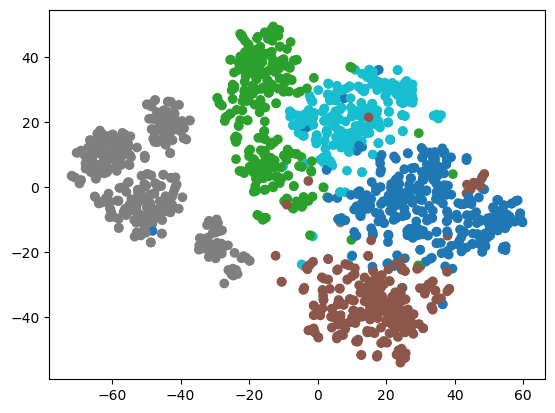

In [40]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=train.Category.astype('category').cat.codes, cmap='tab10')
plt.show()

### Unsupervised model

In this step we will train an unsupervised model and not include the test dataset so that the model will not be evaluated on the same data it was trained with.

In [41]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    {3:'business', 4:'entertainment', 1:'politics', 2:'sport', 0:'tech'}, 0.74
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc

In [42]:
nmf = NMF(n_components=train.Category.nunique(), random_state=11)
nmf.fit(features)
y_pred = np.array([np.argmax(i) for i in nmf.transform(features)])
label_map, acc = label_permute_compare(train.Category, y_pred)
print("Train Accuracy:", acc)


Train Accuracy: 0.9493055555555555


<Axes: >

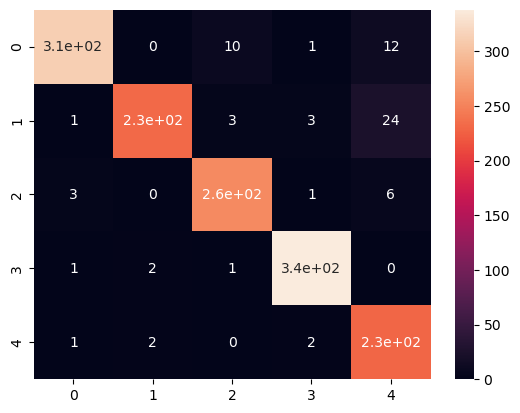

In [59]:
y_pred_label = [label_map[i] for i in y_pred]
conf_matrix = confusion_matrix(train.Category, y_pred_label)
sns.heatmap(conf_matrix, annot=True)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(test.Text).toarray()
labels 

### Supervised model

In this section we will create a supervised model using Logistic Reression. We will train with different data sizes and parameters to evaluate the differences between this method and unsupervised method.

In [60]:
labels = train.Category.factorize()[0]

log_reg = LogisticRegression(random_state=11)
log_reg.fit(features, labels)

y_pred = log_reg.predict(features)
label_map, acc = label_permute_compare(train.Category, y_pred)
print("Train Accuracy:", acc)


Train Accuracy: 0.9972222222222222


<Axes: >

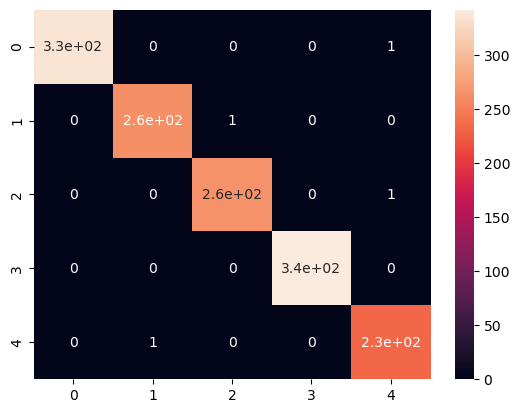

In [61]:
y_pred_label = [label_map[i] for i in y_pred]
conf_matrix = confusion_matrix(train.Category, y_pred_label)
sns.heatmap(conf_matrix, annot=True)

In [62]:
cross_val_score(log_reg, features, labels)

array([0.96875   , 0.95486111, 0.97916667, 0.98263889, 0.97222222])

These cross validation scores indicate that when we split up the data differently we get somewhat different results, however they are all over 95%. In comparison with the unsupervised approach, the supervised model performed better. 

### References

1. https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

2. https://www.kaggle.com/code/akitsuyoshi/text-classification-in-supervised-and-unsupervised